In [1]:
import pandas as pd
import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

In [2]:
get_image_data = ImageDataGenerator(rescale=1./255, validation_split=0.20)

path_name = '/Users/alisongarrett/Documents/GitHub/metis/Deep Learning/Project/data/train'

image_data_train = get_image_data.flow_from_directory(path_name, 
                                                      subset='training', 
                                                      target_size=(256,256), 
                                                      batch_size=32,
                                                      seed=42,
                                                      class_mode='binary')

image_data_validate = get_image_data.flow_from_directory(path_name, 
                                                         subset='validation', 
                                                         target_size=(256,256), 
                                                         batch_size=32,
                                                         seed=42,
                                                         class_mode='binary')



Found 5452 images belonging to 2 classes.
Found 1362 images belonging to 2 classes.


In [3]:
get_image_data = ImageDataGenerator(rescale=1./255)
path_name = '/Users/alisongarrett/Documents/GitHub/metis/Deep Learning/Project/data/test'

image_data_test = get_image_data.flow_from_directory(path_name, 
                                                     target_size=(256,256),
                                                     seed=42,
                                                     class_mode='binary',
                                                     batch_size=32)



Found 884 images belonging to 2 classes.


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


2021-12-01 09:52:55.877166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', #Adam
              metrics=['accuracy'])

In [6]:
callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [7]:
model.fit(
    image_data_train,
#     steps_per_epoch=100,
    epochs=10,
    validation_data=image_data_validate,
#     validation_steps=20, 
    callbacks=[callback])

2021-12-01 09:53:02.125867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
171/171 [==============================] - 149s 867ms/step - loss: 0.7640 - accuracy: 0.5690 - val_loss: 0.7953 - val_accuracy: 0.5683
Epoch 2/10
171/171 [==============================] - 146s 854ms/step - loss: 0.6770 - accuracy: 0.5820 - val_loss: 0.6913 - val_accuracy: 0.5778
Epoch 3/10
171/171 [==============================] - 153s 894ms/step - loss: 0.6724 - accuracy: 0.5794 - val_loss: 0.7367 - val_accuracy: 0.5705
Epoch 4/10
171/171 [==============================] - 153s 892ms/step - loss: 0.6656 - accuracy: 0.5910 - val_loss: 0.8030 - val_accuracy: 0.5257
Epoch 5/10
171/171 [==============================] - 156s 909ms/step - loss: 0.6505 - accuracy: 0.6137 - val_loss: 0.7454 - val_accuracy: 0.5778


In [8]:
model.save('model')

2021-12-01 10:08:52.292322: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


In [11]:
prediction = model.predict(image_data_test, verbose=1)

28/28 [==============================] - 9s 323ms/step


In [12]:
prediction.shape

(884, 1)

In [14]:
image_data_test.class_indices

{'edible': 0, 'poisonous': 1}

In [18]:
actual = np.concatenate((np.zeros((472,1)), np.ones((412,1))), axis=0)

In [19]:
actual.shape

(884, 1)

In [21]:
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve

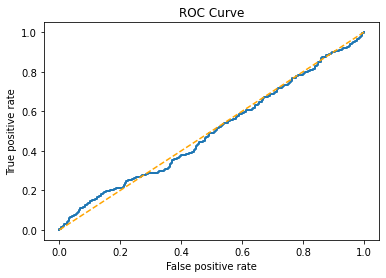

In [33]:
fpr, tpr, thresholds = roc_curve(actual, prediction)

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='orange',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve');

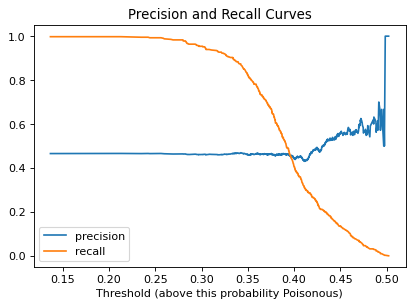

In [26]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(actual, prediction)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability Poisonous)');
plt.title('Precision and Recall Curves');

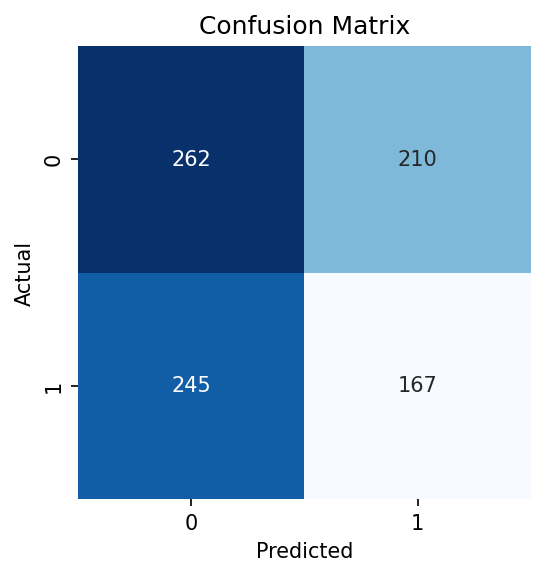

In [31]:
confusion = confusion_matrix(actual, prediction>0.4)
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, cbar=False, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

In [35]:
print('CONV2D:')
print('Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(actual, prediction>0.4), roc_auc_score(actual, prediction>0.4))) 

CONV2D:
Test F1: 0.423, Test AUC: 0.480
